# Fitting the background

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
from astropy.io import ascii

import corner
import glob
import pystan
import pickle
import pandas as pd
import os

Lets read in the data

In [2]:
idx = 4
mal = pd.read_csv('../../data/malatium.csv', index_col=0)
star = mal.loc[idx]
kic = star.KIC
numax = star.numax

In [3]:
sfile = glob.glob('../../data/*{}*.pow'.format(kic))
data = ascii.read(sfile[0]).to_pandas()

In [4]:
cop = pd.read_csv('../../data/copper.csv',index_col=0)
locs = cop[cop.KIC == str(kic)].Freq.values
lo = locs.min() - 50.
hi = locs.max() + 50.

In [5]:
ff, pp = data['col1'],data['col2']
sel = (ff > lo) & (ff < hi)
f = ff[~sel].values
p = pp[~sel].values

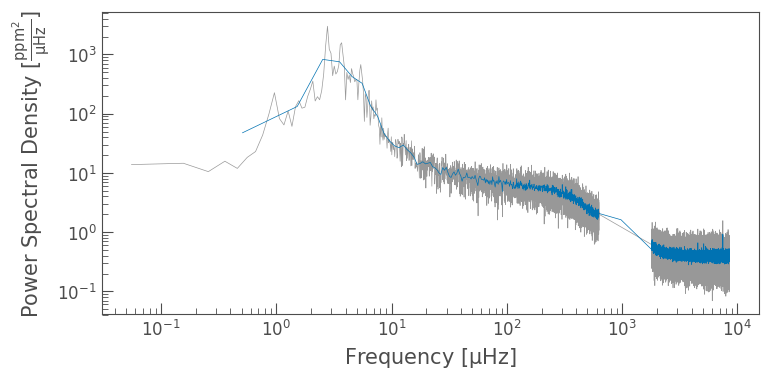

In [17]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
rpg = pg.bin(binsize=10)
ax = pg.plot(alpha=.5,scale='log')
rpg.plot(ax=ax, scale='log')
plt.show()

In [18]:
f = rpg.frequency.value
p = rpg.power.value
print('There are: {} datapoints'.format(len(f)))

There are: 7269 datapoints


In [19]:
overwrite = True
backfit = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    vector[N] f;
    vector[N] p;
    real white_est;
    real nyq_est;
    real numax_est;
    real scale_spread;
}
parameters {
    ordered[2] logca;
    ordered[2] logbd;
    real logj;
    real logk;
    real lognumax;
    real<lower=0> white;
    real<lower=0> nyq;
    real scale;
}
transformed parameters {
    real numax;
    real loga;
    real logb;
    real logc;
    real logd;
    
    loga = logca[2];
    logb = logbd[1];
    logc = logca[1];
    logd = logbd[2];

    numax = 10^lognumax;
}
model {
    real a;
    real b;
    real c;
    real d;
    real j;
    real k;
    real beta[N];

    a = 10^loga;
    b = 10^logb;
    c = 10^logc;
    d = 10^logd;
    j = 10^logj;
    k = 10^logk;

    for (i in 1:N){
        beta[i] = 1. / (apod(f[i], nyq) * scale
                * (harvey(f[i], a, b, 4.0)
                + harvey(f[i], c, d, 4.0)
                + harvey(f[i], j, k, 2.0))
                + white);
        }
    p ~ gamma(1., beta);

    numax_est ~ normal(numax, numax_est*0.1);
    white ~ normal(white_est, white_est*0.3);
    nyq ~ normal(nyq_est, nyq_est*0.01);
    scale ~ normal(1, scale_spread);

    loga ~ normal(3.4 + lognumax *.48, 0.3);
    logb ~ normal(-0.43 + lognumax * 0.86, 0.3);
    logc ~ normal(3.59 + lognumax * -0.59, 0.3);
    logd ~ normal(0.02 + lognumax * 0.96, 0.3);
    logj ~ normal(loga-1, 1.2);
    logk ~ normal(logb-1, 0.2);
}
'''
model_path = 'backfit.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_1b1cde84ce29612f0f6db47952a2ef28 NOW.


Updating Stan model
Reading in Stan model


Guess the parameters

In [20]:
def guess(numax):
    ak, ae = 3.3, -0.48
    bk, be = -0.43, 0.86
    ck, ce = 3.59, -0.59
    dk, de = 0.02, 0.96

    a = 10**(ak + np.log10(numax)*ae)
    b = 10**(bk + np.log10(numax)*be)
    c = 10**(ck + np.log10(numax)*ce)
    d = 10**(dk + np.log10(numax)*de)
    j = a * 0.5
    k = b / 40.0
    scale = 1.0
    
    return [np.log10(a), np.log10(b), 
            np.log10(c), np.log10(d), 
            np.log10(j), np.log10(k), 
            np.log10(numax)]

In [21]:
numax = 2200
white = 1.
p0 = guess(numax)

data = {'N': len(f), 
        'f': f, 'p': p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01}

init = {'loga': p0[0], 'logb': p0[1], 
        'logc': p0[2], 'logd': p0[3],
        'logj': p0[4], 'logk': p0[5],
        'lognumax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [ ]:
nchains = 4
fit = sm.sampling(data=data, iter=5000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

In [ ]:
print(fit)

In [ ]:
fit.plot()
plt.show()

In [ ]:
a = 36.3                                                                
b = 723.52                                                              
c = 31.85                                                               
d = 2002.6                                                              
j = 1.79                                                                
k = 198.31                                                              
white = 0.09  
truths = [a, b, c, d, j, k, white, numax, 1., f[-1]]

In [ ]:
labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [ ]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, numax, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq)**2 * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

def out_modelplot(fit):
    labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
    res = np.array([np.median(fit[label]) for label in labels])
    res[0:6] = 10**res[0:6]
    model = get_background(f, *res)

    pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
    ax = pg.plot(alpha=.25, label='Data', scale='log')
    ax.plot(f, model, label='Model')
    ax.plot(f, harvey(f, res[0],res[1], 4.), label='Harvey 1', ls=':')
    ax.plot(f, harvey(f, res[2],res[3], 4.), label='Harvey 2', ls=':')
    ax.plot(f, harvey(f, res[4],res[5], 2.), label='Harvey 3', ls=':')
    ax.plot(f, get_apodization(f, f[-1]), label='Apod', ls='--')
    ax.plot(f, res[-4]*np.ones_like(f), label='white',ls='-.')
    plt.legend(fontsize=10)
    plt.show()

In [ ]:
out_modelplot(fit)